## **IMPORTING REQUIRED MODULES**

In [1]:
pip install keras-metrics

In [2]:
pip install scikit-plot

In [3]:
import pandas as pd
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from IPython.display import display
import keras_metrics
import keras
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import scikitplot as skplt
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


## **READING THE DATA**

In [0]:
total_data = pd.read_csv("/content/drive/My Drive/IR_PROJECT/facts_opinions.csv")
total_data.head()

,Text,Label
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


## **CLASS-WISE COUNT OF SAMPLES IN THE ENTIRE DATA**

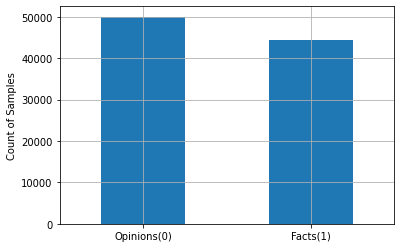

In [0]:
total_data['Label'].value_counts().plot(kind='bar')
plt.grid()
plt.xticks([0,1],["Opinions(0)","Facts(1)"],rotation=360)
plt.ylabel("Count of Samples")
plt.show()

## **DATA PREPROCESSING**


In [0]:
def preproc(data):
  stopword=""
  cleantext = " "
  stopword = set(stopwords.words('english'))
  for i in word_tokenize(data):
    if(any(j.isdigit() for j in i)): ## checking if the word has any numerics...
      continue
    i=i.lower()
    if (i not in stopword) and (len(i)>2):
      pattern1 = '[!.?$\[\]/\}#=<>"\*:,|_~;()^\']'
      pattern2 = '[\n\n]+'
      pattern3 = '[\ \ ]+'
      wout_sc = re.sub(pattern1,'',i) #removing special characters
      wout_el = re.sub(pattern2,'\n',wout_sc) # removing empty lines (which are greater than 2)
      wout_mspaces = re.sub(pattern3,' ',wout_el) # removing multiple spaces
      cleaned_text = wout_mspaces.strip()
      cleaned_text=lemmatizer.lemmatize(cleaned_text)
      if (i not in stopword) and (len(i)>2):
        cleantext = cleantext+cleaned_text+" "
  return cleantext.strip()

In [0]:
for i in tqdm(range(len(total_data)),leave=True,position=0):
  total_data.iloc[i,0] = preproc(total_data.iloc[i,0])

100%|██████████| 94379/94379 [13:28<00:00, 116.68it/s]


## **PREPROCESSED DATA PICKLED**

In [0]:
#pickle_out = open("/content/drive/My Drive/IR_PROJECT/facts_opinions_ppdata.csv","wb")
#pickle.dump(total_data, pickle_out)

## **LOADING THE PREPROCESSED DATA**

In [0]:
pickle_in = open("/content/drive/My Drive/IR_PROJECT/facts_opinions_ppdata.csv","rb")
total_data = pickle.load(pickle_in)

## **DATA AFTER PRE-PROCESSING**

In [5]:
total_data.head()

,Text,Label
0,one reviewer mentioned watching episode hooked...,0
1,wonderful little production filming technique ...,0
2,thought wonderful way spend time hot summer we...,0
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,0


## **SEPERATING OUT TEXT AND CORRESPONDING LABELS**

In [0]:
data_y = pd.DataFrame(data=total_data['Label'],columns=['Label'])
data_x = total_data.drop(columns="Label")

In [7]:
data_y.columns,data_x.columns

(Index(['Label'], dtype='object'), Index(['Text'], dtype='object'))

## **PERFORMING TRAIN-CV-TEST SPLITS**

In [8]:
x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,train_size=0.95,random_state=42)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,train_size=0.95,random_state=42)
print("Shape of X_Train::",x_train.shape)
print("Shape of X_Cv::",x_cv.shape)
print("Shape of X_Test::",x_test.shape)
print("Shape of Y_Train::",y_train.shape)
print("Shape of Y_Cv::",y_cv.shape)
print("Shape of Y_Test::",y_test.shape)

Shape of X_Train:: (85177, 1)
Shape of X_Cv:: (4483, 1)
Shape of X_Test:: (4719, 1)
Shape of Y_Train:: (85177, 1)
Shape of Y_Cv:: (4483, 1)
Shape of Y_Test:: (4719, 1)


## **WRITING TEST DATA INTO CSV FOR VERIFICATION DURING DEPLOYMENT**

In [0]:
x_test.to_csv("/content/drive/My Drive/IR_PROJECT/x_test.csv",index=False)
y_test.to_csv("/content/drive/My Drive/IR_PROJECT/y_test.csv",index=False)

## **CLASS-WISE COUNT OF SAMPLES IN TRAINING DATA**

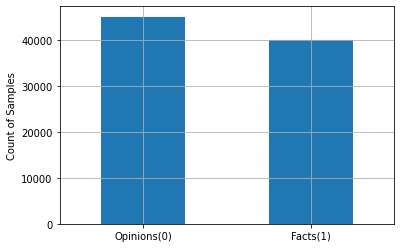

In [0]:
y_train['Label'].value_counts().plot(kind='bar')
plt.grid()
plt.xticks([0,1],["Opinions(0)","Facts(1)"],rotation=360)
plt.ylabel("Count of Samples")
plt.show()
plt.show()

## **CLASS-WISE COUNT OF SAMPLES IN CV DATA**

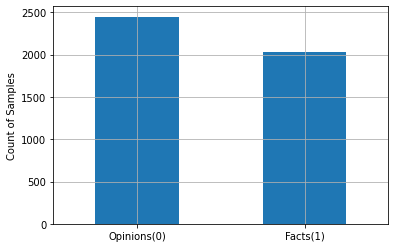

In [0]:
y_cv['Label'].value_counts().plot(kind='bar')
plt.grid()
plt.xticks([0,1],["Opinions(0)","Facts(1)"],rotation=360)
plt.ylabel("Count of Samples")
plt.show()
plt.show()

## **CLASS-WISE COUNT OF SAMPLES IN TEST DATA**

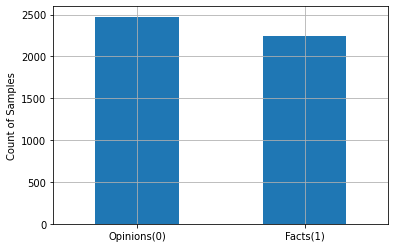

In [0]:
y_test['Label'].value_counts().plot(kind='bar')
plt.grid()
plt.xticks([0,1],["Opinions(0)","Facts(1)"],rotation=360)
plt.ylabel("Count of Samples")
plt.show()
plt.show()

## **MAXIMUM LENGTH OF THE TEXT IN TRAINING DATA**

In [0]:
max_len=0
l=[]
index=[]
for i in range(len(x_train)):
  cur_len = len(x_train.iloc[i,0].split())
  if(cur_len>max_len):
    max_len=cur_len
print("Maximum length of sentence::",max_len)

Maximum length of sentence:: 1383


## **GENEARTING VOCABULARY FROM TRAINING DATA**

In [0]:
vocab={}
for i in tqdm(x_train['Text'],position=0,leave=True):
  for j in i.split():
    if j not in vocab:
      vocab[j]=1
    else:
      vocab[j]+=1
vocab = sorted(vocab, key=vocab.get, reverse=True)

100%|██████████| 85177/85177 [00:02<00:00, 31484.50it/s]


## **VECTORIZING THE DATA**

In [0]:
def vectorize(data,vocab):
  print("\nGenerating Vectors......")
  max_seq_len=1400
  row=0
  ## converting sequence to vector...
  new_data = pd.DataFrame(columns=["Text"])
  for i in tqdm(data['Text'],position=0,leave=True):
    sent=[]
    for j in i.split():
      try:
        sent.append((vocab.index(j))+1)
      except:
        continue
    new_data.loc[row] = [sent]
    row+=1
  new_data = sequence.pad_sequences(new_data['Text'], maxlen=max_seq_len)
  return new_data ## if its CV/TEST data we return the numerical vectors computed w.r.t training vocab

In [0]:
x_train_vec = vectorize(x_train,vocab)
x_cv_vec = vectorize(x_cv,vocab)
x_test_vec = vectorize(x_test,vocab)

  0%|          | 10/85177 [00:00<14:44, 96.31it/s]


Generating Vectors......


  0%|          | 6/4483 [00:00<01:45, 42.32it/s]


Generating Vectors......


  0%|          | 8/4719 [00:00<01:07, 69.88it/s]


Generating Vectors......


100%|██████████| 4719/4719 [01:15<00:00, 62.76it/s]


## **THE LSTM ARCHITECTURE**

In [0]:
lstm_model = Sequential()
lstm_model.add(Embedding(1+len(vocab),20,input_length=1400)) #taking whole length of vocab
lstm_model.add(LSTM(20))
lstm_model.add(Dense(2, activation='softmax'))
checkpoint = ModelCheckpoint('/content/drive/My Drive/IR_PROJECT/saved models/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  
lstm_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values=lstm_model.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),nb_epoch=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint])

Train on 85177 samples, validate on 4483 samples
Epoch 1/3
85177/85177 [==============================] - 334s 4ms/step - loss: 0.1268 - acc: 0.9460 - val_loss: 0.0549 - val_acc: 0.9837

Epoch 00001: val_loss improved from inf to 0.05487, saving model to /content/drive/My Drive/IR_PROJECT/saved models/model-001-0.946042-0.983716.h5
Epoch 2/3
85177/85177 [==============================] - 343s 4ms/step - loss: 0.0248 - acc: 0.9931 - val_loss: 0.0424 - val_acc: 0.9862

Epoch 00002: val_loss improved from 0.05487 to 0.04245, saving model to /content/drive/My Drive/IR_PROJECT/saved models/model-002-0.993085-0.986170.h5
Epoch 3/3
85177/85177 [==============================] - 345s 4ms/step - loss: 0.0086 - acc: 0.9979 - val_loss: 0.0520 - val_acc: 0.9873

Epoch 00003: val_loss did not improve from 0.04245


## **EPOCHS V/S LOSS**

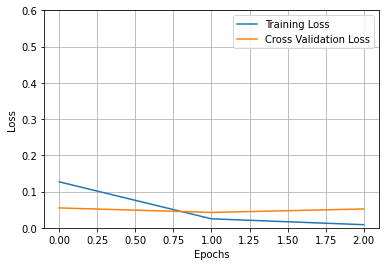

In [0]:
plt.plot(values.history['loss'],label = "Training Loss")
plt.plot(values.history['val_loss'],label = "Cross Validation Loss")
plt.ylim([0,0.60])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

## **EPOCHS V/S ACCURACY**

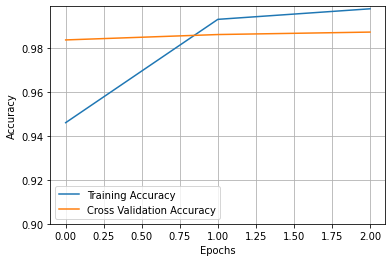

In [0]:
plt.plot(values.history['acc'],label = "Training Accuracy")
plt.plot(values.history['val_acc'],label = "Cross Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.900,0.999])
plt.grid()
plt.legend()
plt.show()

## **PERFORMANCE ON TEST DATA**

#### **CONFUSION MATRIX ON TEST DATA**

In [0]:
from sklearn.metrics import confusion_matrix
from IPython.display import display
classes=["Opinions","Facts "]
y_pred = lstm_model.predict_classes(x_test_vec)
conf_df = pd.DataFrame(confusion_matrix(y_test,y_pred),columns=classes,index=classes)
conf_df.index.name = 'True labels'
display(conf_df)

,Opinions,Facts
True labels,,
Opinions,2442,33
Facts,32,2212


#### **ACCURACY ON TEST DATA**

In [0]:
numer = conf_df.iloc[0,0]+conf_df.iloc[1,1]
denom = conf_df.iloc[0,0]+conf_df.iloc[0,1]+conf_df.iloc[1,0]+conf_df.iloc[1,1]
print("Accuracy on Test Data::",100*numer/denom)

Accuracy on Test Data:: 98.62258953168045


## **VOCABULARY WRITTEN TO A PICKLE FILE**

In [0]:
#pickle_out = open("/content/drive/My Drive/IR_PROJECT/vocab","wb")
#pickle.dump(vocab, pickle_out)

In [0]:
pickle_in = open("/content/drive/My Drive/IR_PROJECT/vocab","rb")
vocab2 = pickle.load(pickle_in)

## **SAVING THE MODEL**

In [0]:
#pickle_out = open("/content/drive/My Drive/IR_PROJECT/saved models/LSTM_model_2","wb")
#pickle.dump(lstm_model, pickle_out)

In [0]:
pickle_in = open("/content/drive/My Drive/IR_PROJECT/saved models/LSTM_model_2","rb")
lstmtest = pickle.load(pickle_in)